ATML Project


In [1]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
import os
import codecs
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_classif
import unicodedata
# so i tried out nltk regexp cause of: https://towardsdatascience.com/benchmarking-python-nlp-tokenizers-3ac4735100c5
from nltk.tokenize.regexp import regexp_tokenize
from nltk.tokenize import word_tokenize
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.naive_bayes import GaussianNB
from spacy.lemmatizer import Lemmatizer
# from spacy.lang.en import LEMMA_INDEX, LEMMA_EXC, LEMMA_RULES
from sklearn.metrics import classification_report
import statsmodels
from statsmodels.stats.weightstats import ttest_ind
import seaborn as sns

In [2]:
#function for reading a csv
def read_csv(filename):
    #takes a absolute or relative path of a .csv file and returns a pd dateframe
    #problems occured: pd.read_csv did not worked: no encoding like utf-8 could decode byte 0x97 in position 5472
    
    
    with open(filename, newline='') as csvfile:
        #stores words in a csv.reader object
        reader = csv.reader(csvfile, delimiter=';')
        #init empty list
        l=[]
        #it thrue rows of reader
        for row in reader:
            #append each row (first converted to numpy array) to list
            l.append(np.array(row))
    #convert list to numpy array
    l=np.array(l)
    #return a Dataframe where the column names are the first row of the numpy array and the rest is the data
    return pd.DataFrame(l[1:],columns=l[0])

def get_books(book_id_col,html_files_path):
    book_l=list(map(lambda x: x.replace('.epub','-content.html'),book_id_col))

    gb_book=[]
    for book in book_l:
        f=codecs.open(html_files_path+book,'r','utf-8')
        doc=f.read().replace('<p>','')
        gb_book.append([book.replace('-content.html','.epub'),doc])
    #generate dataframe with book_id and content
    return pd.DataFrame(gb_book,columns=['book_id','content'])


def preprocess(inputs,lower=False, remove_space=True, keep_accents=False):
    if remove_space:
        outputs = ' '.join(inputs.strip().split())
    else:
        outputs = inputs
    
    outputs = outputs.replace("``", '"').replace("''", '"')
    if not keep_accents:
        outputs = unicodedata.normalize('NFKD', outputs)
        outputs = ''.join([c for c in outputs if not unicodedata.combining(c)])
    if lower:
        outputs = outputs.lower()

    return outputs      
def preprocessing(book_pd,tokenizer='NTLK_regexp'):
    # tokenizer can be "NTLK_regexp" if we ant to use regular expressions for tokenization
    # tokenizer can be "NLTK_words" (result is only small different)
    content_data=[]
    for i_doc in np.array(book_pd['content']):
        #tokenize
        if tokenizer=='NTLK_regexp':
            words=regexp_tokenize(preprocess(i_doc),pattern =r'\w+')
        elif tokenizer=="NLTK_words":
            words = word_tokenize(i_doc)
        #stopword removal
        stop_words = set(stopwords.words('english')) 
        filtered_sentence = [w for w in words if not w in stop_words] 
        
        #lemmatizer
        lemmatizer = WordNetLemmatizer()
        doc=[]
        for w in filtered_sentence: 
            doc.append(lemmatizer.lemmatize(w))
        content_data.append(doc)
    return content_data
def list_of_list_2_list_of_str(book_list):
    txt_data=[]
    for cd in book_list:
        txt_data.append(' '.join(cd))
    return txt_data

In [3]:
#display label dataframe with the information of the books
info_df=read_csv('master996.csv')
book_pd=get_books(info_df['book_id'],'Gutenberg_19th_century_English_Fiction/')
proc_books=preprocessing(book_pd,'NLTK_words')

#to count vectorization
vectorizer = CountVectorizer()
x=vectorizer.fit_transform(list_of_list_2_list_of_str(proc_books)).toarray()

In [7]:
#to get label and books relation in form of one hot encoding
labels = info_df['guten_genre'].unique()
bookid_labels_df = info_df.iloc[:, 1:3]
df = pd.DataFrame(columns=labels)
for i in labels:
    one_hot_vector = []
    for j in range(len(bookid_labels_df)):
        if(bookid_labels_df.iloc[j:j+1, 1:2].values[0][0] == i):
            one_hot_vector.append(1)
        else:
            one_hot_vector.append(0)
    df[i] = one_hot_vector  
df

Detective and Mystery  Literary  Western Stories  Ghost and Horror  \
0                        1         0                0                 0   
1                        0         1                0                 0   
2                        0         1                0                 0   
3                        0         0                1                 0   
4                        0         1                0                 0   
..                     ...       ...              ...               ...   
991                      0         1                0                 0   
992                      0         1                0                 0   
993                      1         0                0                 0   
994                      1         0                0                 0   
995                      0         1                0                 0   

     Christmas Stories  Love and Romance  Sea and Adventure  Allegories  \
0                    0                 0                  0           0   
1                    0                 0                  0           0   
2                    0                 0                  0           0   
3                    0                 0                  0           0   
4                    0                 0                  0           0   
..                 ...               ...                ...         ...   
991                  0                 0                  0           0   
992                  0                 0                  0           0   
993                  0                 0                  0           0   
994                  0                 0                  0           0   
995                  0                 0                  0           0   

     Humorous and Wit and Satire  
0                              0  
1                              0  
2                              0  
3                              0  
4                              0  
..                           ...  
991                            0  
992                            0  
993                            0  
994                            0  
995                            0  

[996 rows x 9 columns]

In [8]:
target = df.to_numpy

In [9]:
#t-test should be passed as a function to SelectKBest hence creating a function(1-D,2-D)
def t_test(x,target):
#t-test feature selection
    t_stat = []
    p_value = []
    deg_of_free = []
    for i in range(len(x[1])):
        feature = x[:,i:i+1]
        tstat, pvalue, dof = statsmodels.stats.weightstats.ttest_ind(feature, target, alternative='two-sided')
        t_stat.append(tstat)
        p_value.append(pvalue)
        deg_of_free.append(dof)
    return t_stat

In [11]:
call_ttest = t_test(x, target)

IndexError: tuple index out of range

In [ ]:
#alternate t-test function without the loop due to dimensional constraints(Both are 2-D inputs)
def t_test(x,target):
#t-test feature selection    
    tstat, pvalue, dof = statsmodels.stats.weightstats.ttest_ind(feature, target, alternative='two-sided')
    return t_stat

In [ ]:
# tstat, pvalue, dof = statsmodels.stats.weightstats.ttest_ind(x.T, target, alternative='two-sided')
# tstat

In [36]:
#target is originally of series type, 
#converting it to numpy to pass as a suitable paramater into selectkbest
target = df.to_numpy()
best_features = SelectKBest(t_test, k=2).fit_transform(x, target)

ValueError: too many values to unpack (expected 2)

Observations :

Feature df is 996 X 157417 (books X features)
Target df is 996 x 9(books X labels
t-test only does pairwise comparisons

Task 1 : Initially passed Feature df as a 1-D array and Target df as a 2-D array to the t-test function. 
Output : 1,57,417 numpy arrays with 9 values in each(for 9 labels)

Task 2 : Passed both df as 2-D 
Output : Faced Broadcast error

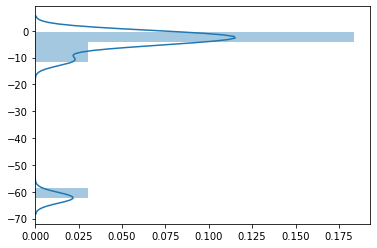

In [29]:
#Plotting t_stat values
ax = sns.distplot(t_stat[10], vertical=True)
#ax = sns.distplot(x, vertical=True)

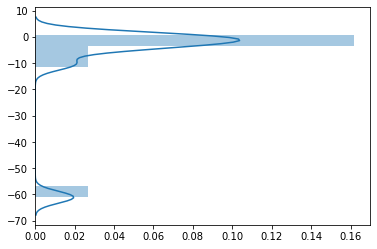

In [30]:
bx = sns.distplot(t_stat[20], vertical=True)

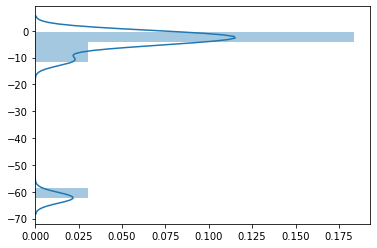

In [32]:
cx = sns.distplot(t_stat[50000], vertical=True)

In [ ]:
#chisquare feature selection
X_new = SelectKBest(chi2, k=2).fit_transform(x, np.array(info_df['guten_genre']))
acc_arr=[]
for k in range(1000,50000,1000):
    X_new = SelectKBest(chi2, k=k).fit_transform(x, np.array(info_df['guten_genre']))
    X_new.shape


    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=0)

    for train_idx,test_idx in sss.split(X_new,np.array(info_df['guten_genre'])):
        x_train = X_new[train_idx]
        x_test = X_new[test_idx]
        y_train = np.array(info_df['guten_genre'])[train_idx]
        y_test = np.array(info_df['guten_genre'])[test_idx]
    gnb = GaussianNB()
    acc=gnb.fit(x_train, y_train).score(x_test,y_test)
    print(acc)
    acc_arr.append(acc)
plt.scatter(x = np.arange(1000,50000,1000),y = acc_arr)
plt.xlabel('k chi2')
plt.ylabel('testaccuracy')
plt.show()

print(classification_report(gnb.predict(x_test), y_test))

In [ ]:
a = np.arange(1000,50000,1000)
a

In [ ]:
X_new.shape

In [ ]:
#mut info feature selection
#did not work
mutual_info_classif
acc_arr2=[]
for k in range(1,1,100):
    X_new = SelectKBest(mutual_info_classif, k=k).fit_transform(x, np.array(info_df['guten_genre']))
    X_new.shape


    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=0)

    for train_idx,test_idx in sss.split(X_new,np.array(info_df['guten_genre'])):
        x_train = X_new[train_idx]
        x_test = X_new[test_idx]
        y_train = np.array(info_df['guten_genre'])[train_idx]
        y_test = np.array(info_df['guten_genre'])[test_idx]
    gnb = GaussianNB()
    acc=gnb.fit(x_train, y_train).score(x_test,y_test)
    print(acc)
    acc_arr2.append(acc)
plt.scatter(np.arange(1000,50000,1000),acc_arr2)
plt.xlabel('k chi2')
plt.ylabel('testaccuracy')